In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
# Load dataset

In [2]:
df = pd.read_csv(r"C:\Users\LENOVO\retail_sales_forecasting\data\retail_store_inventory.csv", parse_dates=['Date'])

In [ ]:
# Filter single store and product for example

In [4]:
store_id = 'S001'
product_id = 'P0001'  # choose appropriate product_id existing in data
df_store_product = df[(df['Store ID'] == store_id) & (df['Product ID'] == product_id)]

In [ ]:
# Aggregate units sold daily

In [5]:
df_agg = df_store_product.groupby('Date').agg({
    'Units Sold': 'sum',
    'Price': 'mean',
    'Discount': 'mean',
    'Holiday/Promotion': 'max',  # treat as binary exog
    # You can also include weather or competitor pricing if numerical and meaningful
}).reset_index()
df_agg.set_index('Date', inplace=True)

In [ ]:
# Split train/test

In [6]:
train = df_agg.loc[:'2023-04-30']
test = df_agg.loc['2023-05-01':]

In [ ]:
# SARIMAX Model with exogenous variables: price, discount, holiday/promotion

In [7]:
model = sm.tsa.statespace.SARIMAX(
    train['Units Sold'],
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    exog=train[['Price', 'Discount', 'Holiday/Promotion']]
)

sarimax_res = model.fit(disp=False)

C:\Users\LENOVO\anaconda3new\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\LENOVO\anaconda3new\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
# Forecast

In [8]:
forecast = sarimax_res.get_forecast(steps=len(test), exog=test[['Price', 'Discount', 'Holiday/Promotion']])
pred_ci = forecast.conf_int()

In [ ]:
# Plot results

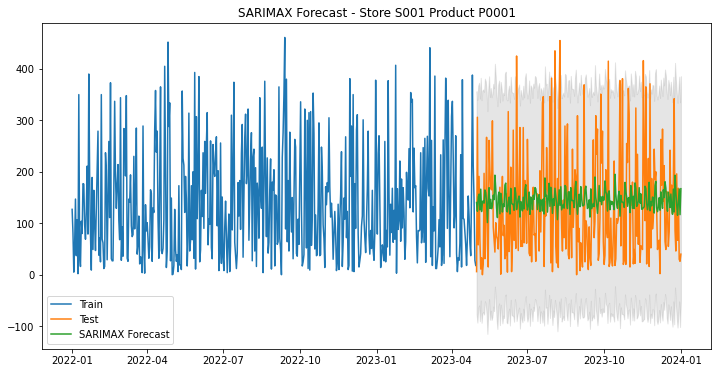

In [9]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train['Units Sold'], label='Train')
plt.plot(test.index, test['Units Sold'], label='Test')
plt.plot(test.index, forecast.predicted_mean, label='SARIMAX Forecast')
plt.fill_between(test.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='gray', alpha=0.2)
plt.title(f'SARIMAX Forecast - Store {store_id} Product {product_id}')
plt.legend()
plt.show()